# Appendices

In [1]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 77.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
# For warnings
import warnings
warnings.filterwarnings(action='ignore')
from scikeras.wrappers import KerasClassifier
# Importing necessary packages for building and tuning our model
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.under_sampling import NearMiss               # For Undersampling
from imblearn.over_sampling import RandomOverSampler       # For Oversampling
from imblearn.combine import SMOTETomek                    # For Both Undersampling & Oversampling
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras_tuner.tuners import RandomSearch

# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

2024-04-29 12:05:41.576557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 12:05:41.576658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 12:05:41.711598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = pd.read_pickle("/kaggle/input/pickle121/lending_club_dataset.pickle")

In [4]:
dat = data[0]

In [5]:
dat.shape

(605374, 33)

#  Data Exploration

In [6]:
df = dat.drop(columns=['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc'])
df.isnull().sum()

id                         0
loan_amnt                  0
funded_amnt                0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             37891
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
open_acc                   0
pub_rec                    0
fico_range_high            0
fico_range_low             0
revol_bal                  0
revol_util                 0
total_pymnt                0
last_pymnt_d               0
recoveries                 0
loan_length                0
term_num                   0
dtype: int64

In [7]:
selected_columns = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
dat[selected_columns]

,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
0,0.031676,0.103917,0.031155,0.050634,0.086751
2,0.067688,0.064215,0.050574,0.066334,0.094950
3,0.029354,0.105803,0.029798,0.049345,0.085622
4,0.061736,0.061721,0.047093,0.063007,0.091937
5,0.102442,0.136655,0.113866,0.131897,0.164518
...,...,...,...,...,...
1048430,0.030100,0.182219,0.030735,0.051117,0.089089
1048442,0.011731,0.140018,0.024141,0.044108,0.081340
1048471,0.028473,0.203910,0.029807,0.050279,0.088453
1048488,0.006092,0.222524,0.016028,0.035984,0.073344


In [8]:
# List of columns to sum
columns_to_sum = ['ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']


# Calculate the sum across columns
return_max_sum = dat[columns_to_sum].sum(axis=1)

# Binarize the sum values into two classes
y_binary = np.where(return_max_sum > return_max_sum.median(), 1, 0)


y1 = y_binary
# Print the first few values of y_binary


In [9]:
# Calculate the percentage of missing values in df_read
percentage_missing = df.isnull().sum() / len(df) * 100

# Create a new DataFrame with columns from df and index set to None
new_df = pd.DataFrame(columns=df.columns, index=None)
pd.set_option('display.max_columns', None)

# Creating new Percentage index
new_df.loc['Percentage'] = percentage_missing.values
new_df

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num
Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.259106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Keeping only those features with less than 20% of missing values
features_to_keep = df.columns[((df.isnull().sum()/len(df))*100 < 20)].to_list()
print("Total features before:",len(df.columns))
print("Total features now:",len(features_to_keep))

Total features before: 28
Total features now: 28


In [11]:
df.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,recoveries,loan_length,term_num
count,605374.000000,605374.000000,605374.00000,605374.000000,6.053740e+05,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000,6.053740e+05,605374.000000,605374.000000,605374.000000,605374.000000,605374.000000
mean,14552.362506,14552.362506,12.69876,439.151480,7.687993e+04,18.969691,0.338577,11.846685,0.239870,699.438314,695.438159,1.657829e+04,50.717241,14601.370444,254.129004,20.106174,41.682464
std,8795.106114,8795.106114,4.77739,262.995589,7.277882e+04,11.783039,0.920335,5.676809,0.641496,31.856039,31.855308,2.359003e+04,24.453887,10175.431179,982.899170,11.594011,10.202397
min,1000.000000,1000.000000,5.31000,14.010000,1.600000e+01,-1.000000,0.000000,1.000000,0.000000,664.000000,660.000000,0.000000e+00,0.000000,17.580000,0.000000,0.919937,36.000000
25%,8000.000000,8000.000000,9.17000,248.442500,4.571275e+04,12.190000,0.000000,8.000000,0.000000,674.000000,670.000000,5.856000e+03,32.300000,6704.651477,0.000000,10.020740,36.000000
50%,12000.000000,12000.000000,12.29000,373.920000,6.500000e+04,18.200000,0.000000,11.000000,0.000000,694.000000,690.000000,1.103700e+04,50.600000,11909.215060,0.000000,18.990123,36.000000
75%,20000.000000,20000.000000,15.59000,583.890000,9.181350e+04,24.980000,0.000000,15.000000,0.000000,714.000000,710.000000,1.985600e+04,69.300000,20320.256235,0.000000,31.047865,36.000000
max,40000.000000,40000.000000,30.99000,1719.830000,9.550000e+06,999.000000,39.000000,90.000000,86.000000,850.000000,845.000000,2.904836e+06,193.000000,61184.573800,35581.880000,49.939424,60.000000


In [12]:
df.isnull().sum()

id                         0
loan_amnt                  0
funded_amnt                0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             37891
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
open_acc                   0
pub_rec                    0
fico_range_high            0
fico_range_low             0
revol_bal                  0
revol_util                 0
total_pymnt                0
last_pymnt_d               0
recoveries                 0
loan_length                0
term_num                   0
dtype: int64

In [13]:
df['emp_length']=df['emp_length'].fillna(df['emp_length'].mode()[0])

# Handling null values

In [14]:
df['revol_util']=df['revol_util'].fillna(df['revol_util'].median())

In [15]:
df.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num
0,40390412,5000.0,5000.0,36 months,12.39,167.01,C,< 1 year,RENT,48000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,14.25,0.0,2010-07-01,7.0,0.0,674.0,670.0,5994.0,44.4,5475.14000,2015-12-01,0.0,10.973531,36
2,40401108,17000.0,17000.0,36 months,12.39,567.82,C,1 year,RENT,53000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,21.31,0.0,2006-09-01,12.0,0.0,684.0,680.0,14690.0,73.1,20452.09912,2018-03-01,0.0,37.947391,36
3,40501689,9000.0,9000.0,36 months,14.31,308.96,C,6 years,RENT,39000.0,Source Verified,2015-01-01,Fully Paid,credit_card,24.80,0.0,1982-11-01,10.0,0.0,719.0,715.0,26172.0,77.7,9792.56000,2015-11-01,0.0,9.987885,36
4,40352737,14000.0,14000.0,36 months,11.99,464.94,B,6 years,RENT,44000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,18.41,0.0,2001-04-01,11.0,0.0,664.0,660.0,14330.0,34.8,16592.91130,2018-01-01,0.0,36.008953,36
5,40431323,10000.0,10000.0,60 months,19.24,260.73,E,10+ years,MORTGAGE,130000.0,Verified,2015-01-01,Fully Paid,debt_consolidation,13.73,0.0,1999-03-01,12.0,0.0,709.0,705.0,5947.0,44.1,15122.07997,2018-10-01,0.0,44.978336,60


# Visualization

# Count Plot

Text(0.5, 1.0, 'Loan status count')

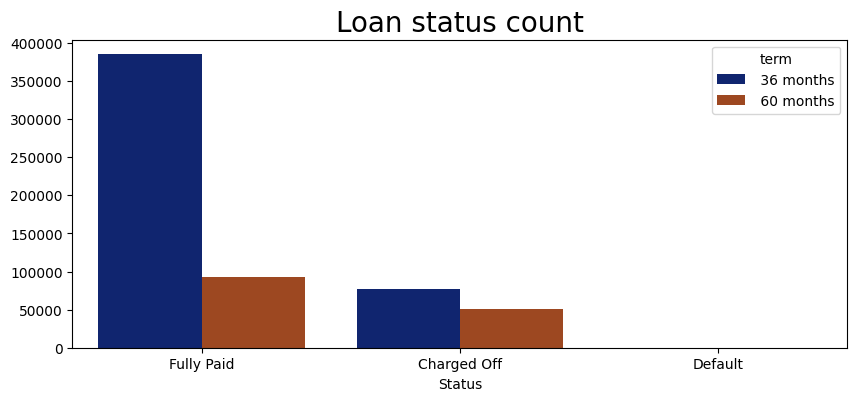

In [16]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(data=df,x="loan_status",hue="term",palette='dark')
ax.set(xlabel='Status', ylabel='')
ax.set_title('Loan status count', size=20)

Text(0.5, 1.0, 'Loan status count')

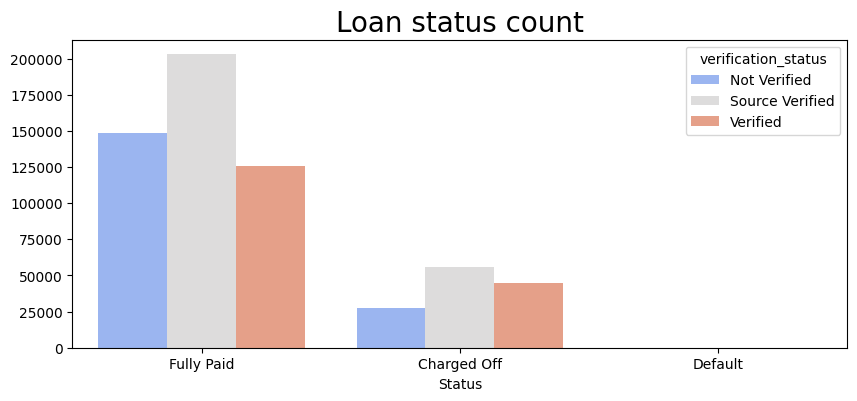

In [17]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(data=df,x="loan_status",hue="verification_status",palette='coolwarm')
ax.set(xlabel='Status', ylabel='')
ax.set_title('Loan status count', size=20)

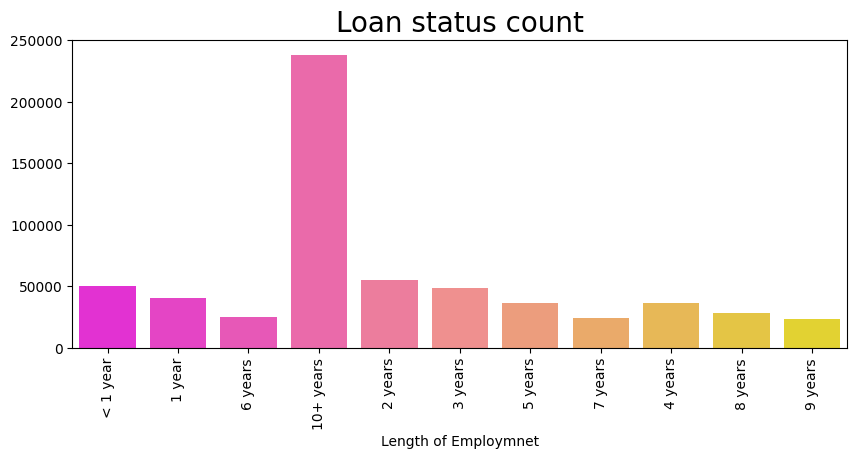

In [18]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(data=df,x="emp_length",palette='spring')
ax.set(xlabel='Length of Employmnet', ylabel='')
ax.set_title('Loan status count', size=20)
plt.xticks(rotation='vertical')
plt.show()

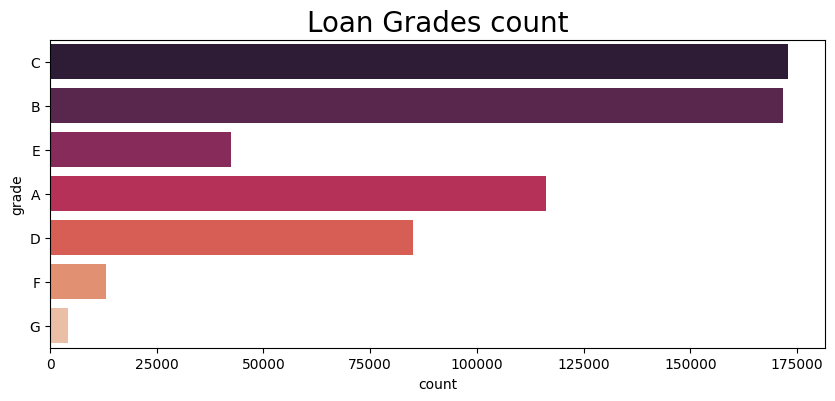

In [19]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(data=df,y="grade",palette='rocket')
ax.set_title('Loan Grades count', size=20)
plt.show()

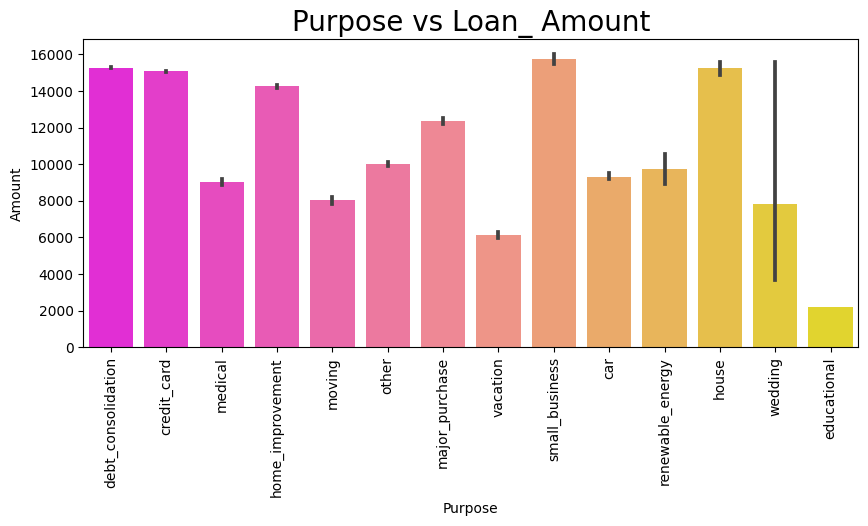

In [20]:
fig, ax =plt.subplots(figsize=(10,4))
sns.barplot(data=df,x="purpose",y='loan_amnt',palette='spring')
ax.set(xlabel='Purpose', ylabel='Amount')
ax.set_title('Purpose vs Loan_ Amount', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Bar plot

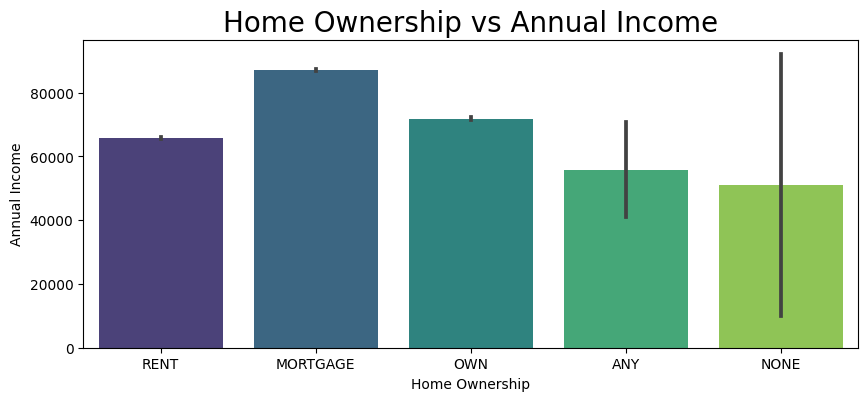

In [21]:
fig, ax =plt.subplots(figsize=(10,4))
sns.barplot(data=df,x="home_ownership",y='annual_inc',palette='viridis')
ax.set(xlabel='Home Ownership', ylabel='Annual Income')
ax.set_title('Home Ownership vs Annual Income', size=20)
plt.show()

In [22]:
# Dividing our features into categorical and numerical
categorical=[feature for feature in df.columns if df[feature].dtype=='object']
numerical=[feature for feature in df.columns if feature not in categorical]

# Heatmap

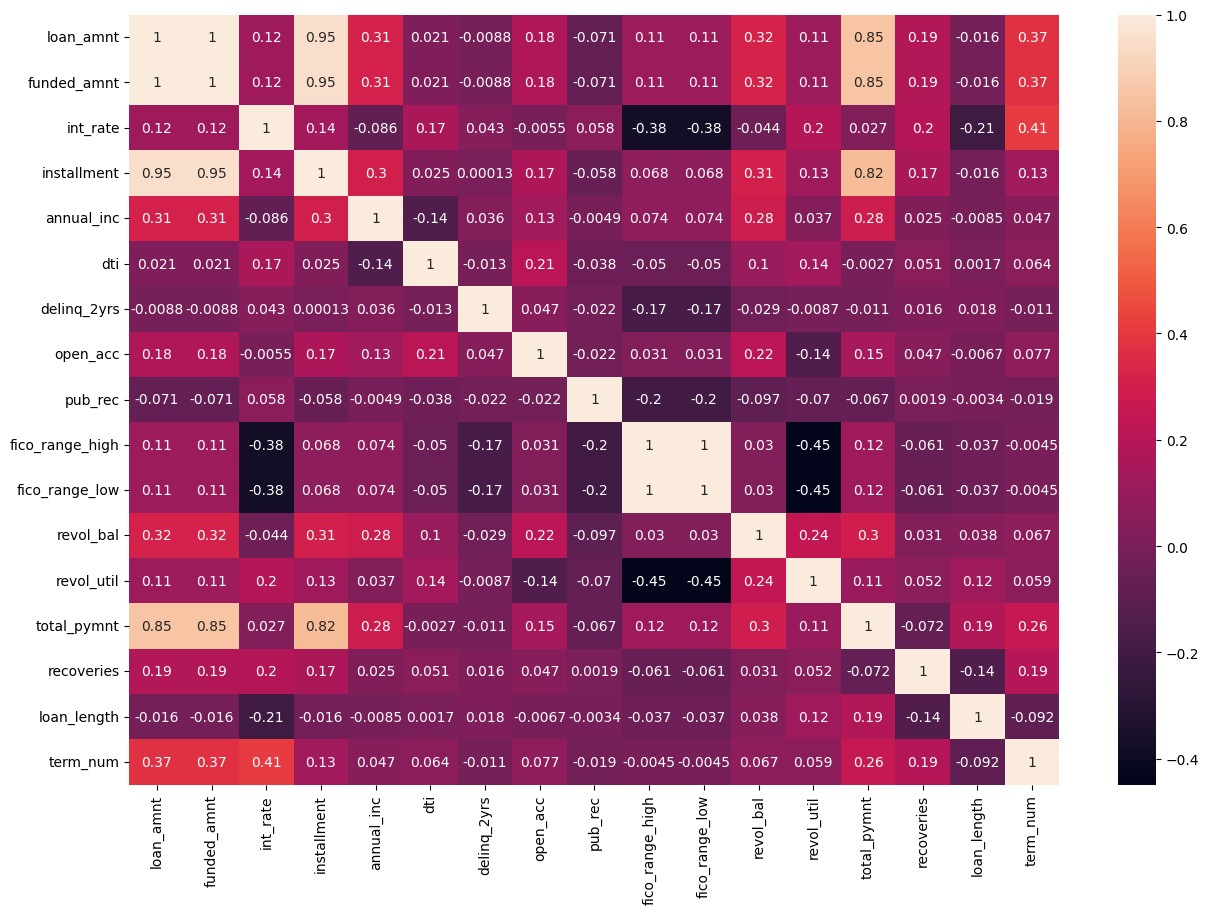

In [23]:
# Plotting a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df[numerical].corr(), annot=True)
plt.show()


# Displaying Catagorical and Numerical Data

In [24]:
print("Categorical columns:",categorical)
print("Numerical columns:",numerical)

Categorical columns: ['id', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']
Numerical columns: ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'loan_length', 'term_num']


# Preprocessing Data

In [25]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Default'], dtype=object)

In [26]:


# Replace 'Default' with 1 and all other values with 0
df['loan_status'] = np.where(df['loan_status'] == 'Default', 1, 0)


In [27]:
df['loan_status']

0          0
2          0
3          0
4          0
5          0
          ..
1048430    0
1048442    0
1048471    0
1048488    0
1048541    0
Name: loan_status, Length: 605374, dtype: int64

In [28]:
8# One hot encoding
df=pd.get_dummies(data=df,columns=['home_ownership','verification_status','purpose'],drop_first=True, dtype=np.uint8)


In [29]:
df.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,annual_inc,issue_d,loan_status,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_length,term_num,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,40390412,5000.0,5000.0,36 months,12.39,167.01,C,< 1 year,48000.0,2015-01-01,0,14.25,0.0,2010-07-01,7.0,0.0,674.0,670.0,5994.0,44.4,5475.14000,2015-12-01,0.0,10.973531,36,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,40401108,17000.0,17000.0,36 months,12.39,567.82,C,1 year,53000.0,2015-01-01,0,21.31,0.0,2006-09-01,12.0,0.0,684.0,680.0,14690.0,73.1,20452.09912,2018-03-01,0.0,37.947391,36,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,40501689,9000.0,9000.0,36 months,14.31,308.96,C,6 years,39000.0,2015-01-01,0,24.80,0.0,1982-11-01,10.0,0.0,719.0,715.0,26172.0,77.7,9792.56000,2015-11-01,0.0,9.987885,36,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,40352737,14000.0,14000.0,36 months,11.99,464.94,B,6 years,44000.0,2015-01-01,0,18.41,0.0,2001-04-01,11.0,0.0,664.0,660.0,14330.0,34.8,16592.91130,2018-01-01,0.0,36.008953,36,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,40431323,10000.0,10000.0,60 months,19.24,260.73,E,10+ years,130000.0,2015-01-01,0,13.73,0.0,1999-03-01,12.0,0.0,709.0,705.0,5947.0,44.1,15122.07997,2018-10-01,0.0,44.978336,60,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [30]:
print([column for column in df.columns if df[column].dtype == object])

['id', 'term', 'grade', 'emp_length', 'issue_d', 'earliest_cr_line', 'last_pymnt_d']


In [31]:
df.drop(['id', 'issue_d', 'last_pymnt_d'], axis=1, inplace=True)

In [32]:
df.drop('earliest_cr_line',axis=1,inplace=True)

In [33]:
# Term column
print("Before:",df['term'].unique())
df['term'] = df['term'].map(lambda x: x.lstrip(' ').rstrip(' months'))
print("After:",df['term'].unique())
df['term']= df['term'].astype('int64')

Before: [' 36 months' ' 60 months']
After: ['36' '60']


In [34]:
# Define a dictionary to map original values to transformed values
mapping_dict = {
    '< 1 year': '1',
    '1 year': '1',
    '2 years': '2',
    '3 years': '3',
    '4 years': '4',
    '5 years': '5',
    '6 years': '6',
    '7 years': '7',
    '8 years': '8',
    '9 years': '9',
    '10+ years': '10'
}

# Apply the mapping to the 'loan_status' column
df['emp_length'] = df['emp_length'].map(mapping_dict)


In [35]:
df['emp_length'] = df['emp_length'].astype(float)

In [36]:
# Label Encoding
df['grade']= df['grade'].map({'A':0,'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6})


In [37]:
print([column for column in df.columns if df[column].dtype == object])

[]


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605374 entries, 0 to 1048541
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            605374 non-null  float64
 1   funded_amnt                          605374 non-null  float64
 2   term                                 605374 non-null  int64  
 3   int_rate                             605374 non-null  float64
 4   installment                          605374 non-null  float64
 5   grade                                605374 non-null  int64  
 6   emp_length                           605374 non-null  float64
 7   annual_inc                           605374 non-null  float64
 8   loan_status                          605374 non-null  int64  
 9   dti                                  605374 non-null  float64
 10  delinq_2yrs                          605374 non-null  float64
 11  open_acc         

# Step 1

# Investment Strategy Based on Return Maximizing

1. **Data Observation**: We began by thoroughly examining the dataset's columns to understand the available return metrics and their implications.

2. **Return Metrics Identification**: Through our analysis, we identified various return metrics, including optimistic, intermediate, and pessimistic returns.

3. **Objective Setting**: Our goal was to select the most favorable return metric while avoiding overly conservative estimates to maximize returns effectively.

4. **Evaluation Process**: Each return metric underwent meticulous evaluation based on historical performance and associated risk factors.

5. **Optimal Return Selection**: The optimal return metric consistently demonstrated the highest returns across historical data, making it a prime candidate for portfolio optimization.

6. **Combination Strategy**: We opted to combine the optimal return with intermediate returns to strike a balance between maximizing returns and managing risk.

7. **Risk Mitigation**: By avoiding overly pessimistic return metrics, we aimed to capture potential upside while still maintaining a prudent approach to risk management.

8. **Evidence-based Decision**: Our decision-making process was grounded in empirical evidence from historical loan performance data, ensuring a robust and data-driven approach.

In [39]:
# Dividing our dataset into independent and dependent features
X1=df.drop('loan_status',axis=1)

In [40]:
# Splitting our dataset between training and testing set
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.25,random_state=100)

In [41]:
# MinMax Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
model1=RandomForestClassifier()
model1.fit(X_train,y_train)

RandomForestClassifier()

In [43]:
y_pred=model1.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[71406  4330]
 [ 1585 74023]]


Accuracy Score: 
 0.9609168516756528


Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     75736
           1       0.94      0.98      0.96     75608

    accuracy                           0.96    151344
   macro avg       0.96      0.96      0.96    151344
weighted avg       0.96      0.96      0.96    151344



In [44]:
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler()
X_train_os,y_train_os=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

The number of classes before fit Counter({1: 227079, 0: 226951})
The number of classes after fit Counter({0: 227079, 1: 227079})


In [45]:
# Define the build_model function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [46]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=3, executions_per_trial=2)
tuner.search(X_train_os, y_train_os, epochs=10, validation_data=(X_test, y_test))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
             # Storing my best hyperparameters in the best_hps variable.

Trial 3 Complete [00h 11m 12s]
val_accuracy: 0.9679703116416931

Best val_accuracy So Far: 0.9679703116416931
Total elapsed time: 00h 42m 06s


In [47]:
# Define the create_model function to build a Keras model with the optimal hyperparameters
def create_model(num_layers, num_nodes, activation):
    model = keras.Sequential()
    for i in range(num_layers):
        if i==0:                                                           # checks whether the current layer is the first layer of the model.
            model.add(layers.Dense(num_nodes[i], input_dim=X_train.shape[1]))
            model.add(layers.Activation(activation))
            model.add(layers.Dropout(0.3))
        else:
            model.add(layers.Dense(num_nodes[i]))
            model.add(layers.Activation(activation))
            model.add(layers.Dropout(0.3))       
    model.add(layers.Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate a list of integers for the number of nodes in each layer
num_nodes = [best_hps.get('units_' + str(i)) for i in range(best_hps.get('num_layers'))]

model = KerasClassifier(
    build_fn=create_model,
    num_layers=best_hps.get('num_layers'),
    num_nodes=num_nodes,
    activation='relu'
)

In [48]:
# Fit the Keras Classifier model with the optimal hyperparameters
mymodel= model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
14189/14189 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.8952 - loss: 0.2361 - val_accuracy: 0.9589 - val_loss: 0.1099
Epoch 2/20
14189/14189 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9492 - loss: 0.1304 - val_accuracy: 0.9595 - val_loss: 0.1129
Epoch 3/20
14189/14189 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9526 - loss: 0.1216 - val_accuracy: 0.9598 - val_loss: 0.1011
Epoch 4/20
14189/14189 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9543 - loss: 0.1160 - val_accuracy: 0.9598 - val_loss: 0.0988
Epoch 5/20
14189/14189 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9564 - loss: 0.1127 - val_accuracy: 0.9591 - val_loss: 0.1031
Epoch 6/20
14189/14189 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9562 - loss: 0.1117 - val_accuracy: 0.9585 - val_loss: 0.1063
Epoch 7/20
14189/14189 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9565 - loss: 0.1108 - val_accuracy: 0.9607 - val_loss: 0.0974
Epoch 8/20
14189/14189 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 

In [49]:
y_pred=model.predict(X_test)
y_pred = (y_pred > 0.5)

4730/4730 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [50]:
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[70598  5138]
 [  751 74857]]


Accuracy Score: 
 0.9610886457342214


Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     75736
           1       0.94      0.99      0.96     75608

    accuracy                           0.96    151344
   macro avg       0.96      0.96      0.96    151344
weighted avg       0.96      0.96      0.96    151344



# Step 2

# Investment Strategy Based on Default Minimization

In [51]:
# Dividing our dataset into independent and dependent features
X=df.drop('loan_status',axis=1)
y=df['loan_status']

In [52]:
# Splitting our dataset between training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)

In [53]:
# MinMax Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
df['loan_status'].value_counts()

loan_status
0    605353
1        21
Name: count, dtype: int64

In [55]:
print("Fully Paid:",df['loan_status'].value_counts()[0]/len(df['loan_status'])*100)
print("Default:",df['loan_status'].value_counts()[1]/len(df['loan_status'])*100)

Fully Paid: 99.99653107004926
Default: 0.003468929950741195


In [56]:
ns=NearMiss()
X_train_ns,y_train_ns=ns.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 454013, 1: 17})
The number of classes after fit Counter({0: 17, 1: 17})


In [57]:
model1=RandomForestClassifier()
model1.fit(X_train_ns,y_train_ns)

RandomForestClassifier()

In [58]:
y_pred=model1.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[ 17717 133623]
 [     0      4]]


Accuracy Score: 
 0.11709086584205519


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.12      0.21    151340
           1       0.00      1.00      0.00         4

    accuracy                           0.12    151344
   macro avg       0.50      0.56      0.10    151344
weighted avg       1.00      0.12      0.21    151344



In [59]:
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler()
X_train_os,y_train_os=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

The number of classes before fit Counter({0: 454013, 1: 17})
The number of classes after fit Counter({0: 454013, 1: 454013})


In [60]:
# Define the build_model function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [61]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=3, executions_per_trial=2)
tuner.search(X_train_os, y_train_os, epochs=10, validation_data=(X_test, y_test))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
             # Storing my best hyperparameters in the best_hps variable.

Reloading Tuner from ./untitled_project/tuner0.json


In [62]:
# Define the create_model function to build a Keras model with the optimal hyperparameters
def create_model(num_layers, num_nodes, activation):
    model = keras.Sequential()
    for i in range(num_layers):
        if i==0:                                                           # checks whether the current layer is the first layer of the model.
            model.add(layers.Dense(num_nodes[i], input_dim=X_train.shape[1]))
            model.add(layers.Activation(activation))
            model.add(layers.Dropout(0.3))
        else:
            model.add(layers.Dense(num_nodes[i]))
            model.add(layers.Activation(activation))
            model.add(layers.Dropout(0.3))       
    model.add(layers.Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate a list of integers for the number of nodes in each layer
num_nodes = [best_hps.get('units_' + str(i)) for i in range(best_hps.get('num_layers'))]

model = KerasClassifier(
    build_fn=create_model,
    num_layers=best_hps.get('num_layers'),
    num_nodes=num_nodes,
    activation='relu'
)

In [63]:
# Fit the Keras Classifier model with the optimal hyperparameters
mymodel= model.fit(X_train_os, y_train_os, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
28376/28376 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step - accuracy: 0.9886 - loss: 0.0291 - val_accuracy: 0.9996 - val_loss: 0.0034
Epoch 2/20
28376/28376 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9989 - loss: 0.0051 - val_accuracy: 0.9997 - val_loss: 0.0049
Epoch 3/20
28376/28376 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9990 - val_loss: 0.0089
Epoch 4/20
28376/28376 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9998 - val_loss: 0.0088
Epoch 5/20
28376/28376 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 0.9995 - val_loss: 0.0122
Epoch 6/20
28376/28376 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9997 - val_loss: 0.0080
Epoch 7/20
28376/28376 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.9997 - loss: 0.0032 - val_accuracy: 0.9995 - val_loss: 0.0056
Epoch 8/20
28376/28376 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 

In [64]:
y_pred=model.predict(X_test)
y_pred = (y_pred > 0.5)

4730/4730 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [65]:
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[151308     32]
 [     4      0]]


Accuracy Score: 
 0.9997621313035204


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    151340
           1       0.00      0.00      0.00         4

    accuracy                           1.00    151344
   macro avg       0.50      0.50      0.50    151344
weighted avg       1.00      1.00      1.00    151344



# Experiments and Results

Confusion Matrix: 
 [[71371  4365]
 [ 1624 73984]]


Accuracy Score: 
 0.9604278993551115


Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     75736
           1       0.94      0.98      0.96     75608

    accuracy                           0.96    151344
   macro avg       0.96      0.96      0.96    151344
weighted avg       0.96      0.96      0.96    151344


Confusion Matrix: 
 [[ 25043 126297]
 [     1      3]]


Accuracy Score: 
 0.16549053811185116


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.17      0.28    151340
           1       0.00      0.75      0.00         4

    accuracy                           0.17    151344
   macro avg       0.50      0.46      0.14    151344
weighted avg       1.00      0.17      0.28    151344